In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error,mean_squared_log_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import optuna

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r"D:\Data Science\kaggle competitions\playground series season 3 episode 11\playground-series-s3e11\train.csv")
df_test = pd.read_csv(r"D:\Data Science\kaggle competitions\playground series season 3 episode 11\playground-series-s3e11\test.csv")
sample = pd.read_csv(r"D:\Data Science\kaggle competitions\playground series season 3 episode 11\playground-series-s3e11\sample_submission.csv")
df = df.drop(columns = ['id'])
df_test = df_test.drop(columns = ['id'])
df.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


|Features | Description|
|--------|----------|
Store_sales (in millions) | Store sales in millions dollars 
Unit_sales (in millions) | Unit_sales in millions in store
Total_children | Childeren in home 
avg_cars_at home(approx) | Avarage cars at home 
Gross_weight | Gross weight of items
Recyclable_package | Food items is in recylable package 
Low_fat | Food items is low fat 
Units_per_case | Case units available in each store shelves 
Store_sqft | Store area available in SQFT
Coffee_bar | Coffee bar available in store 
Video_store | Video store available in store 
Salad_bar | Salad bar available in store
Prepared_food | Food prepared available in store 
Florist | Flower shelves available in store 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   store_sales(in millions)    360336 non-null  float64
 1   unit_sales(in millions)     360336 non-null  float64
 2   total_children              360336 non-null  float64
 3   num_children_at_home        360336 non-null  float64
 4   avg_cars_at home(approx).1  360336 non-null  float64
 5   gross_weight                360336 non-null  float64
 6   recyclable_package          360336 non-null  float64
 7   low_fat                     360336 non-null  float64
 8   units_per_case              360336 non-null  float64
 9   store_sqft                  360336 non-null  float64
 10  coffee_bar                  360336 non-null  float64
 11  video_store                 360336 non-null  float64
 12  salad_bar                   360336 non-null  float64
 13  prepared_food 

In [5]:
df.nunique()

store_sales(in millions)      1044
unit_sales(in millions)          6
total_children                   6
num_children_at_home             6
avg_cars_at home(approx).1       5
gross_weight                   384
recyclable_package               2
low_fat                          2
units_per_case                  36
store_sqft                      20
coffee_bar                       2
video_store                      2
salad_bar                        2
prepared_food                    2
florist                          2
cost                           328
dtype: int64

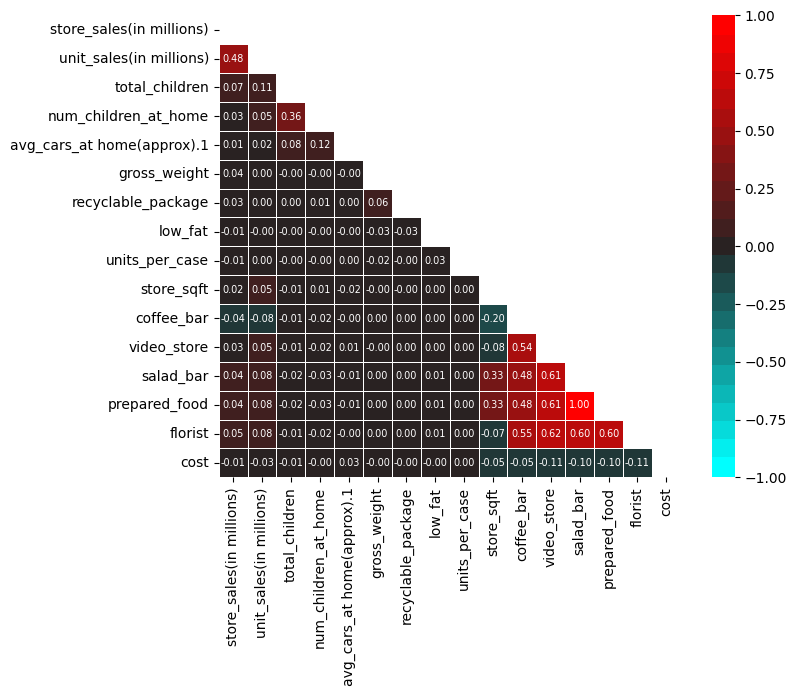

In [6]:
matrix= df.corr()
k=   sns.diverging_palette(220, 20, n=25, center="dark", as_cmap=False, s=500, l=70)

plt.figure(figsize = (8,6))

mask = np.triu(np.ones_like(matrix, dtype=bool))

sns.heatmap(matrix, 
            vmin=-1.0, vmax = 1.0, 
            linewidths = 0.5,
            square= True,
            annot= True,
            mask =mask,
            annot_kws= {'size': 'x-small'},
            fmt = '0.2f', 
            cmap=k,
            center = 0)
plt.show()

Inference: 
* Prepared food and salad bar have 1 correlation, means every salad bar comes from the store where food is prepared. Since both the columns have same value, we will remove one of them.
* Video store, florist, salad_bar, and prepared food are highly correlated with each other, meaning features become highly dependent, therefore I will choose only 1 from them.
* Store_sqft i.e area of the store has good correlatipn with prepared_food meaning stores where food is prepared need are more spacious. 


In [7]:
df = df.drop(columns = ['salad_bar','video_store','florist'])
df_test = df_test.drop(columns = ['salad_bar','video_store','florist'])

### Modeling

In [9]:
features = df.drop(columns = 'cost')
target = df.cost

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 0)

In [11]:
ss =StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [12]:
def model_validation(y_test, y_pred):
    print(f"r2_score :{r2_score(y_test,y_pred)}")
    print(f"mean absolute error :{mean_absolute_error(y_test, y_pred)}")
    print(f"root mean squared log error :{np.sqrt(mean_squared_log_error(y_test, y_pred))}")
    print(f"root mean squared error :{np.sqrt(mean_squared_error(y_test, y_pred))}")
    
    return np.sqrt(mean_squared_log_error(y_test, y_pred))

### Linear Regression

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [15]:
lr_rmsle = model_validation(y_test, y_pred)

r2_score :0.011652892679545834
mean absolute error :25.69623709800065
root mean squared log error :0.31844362330783144
root mean squared error :29.76208120893452


### Decision Tree Regressor

In [16]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)

In [17]:
dtr_rmsle = model_validation(y_test, y_pred)

r2_score :-0.7721098444478338
mean absolute error :30.276906134078317
root mean squared log error :0.4212014596189348
root mean squared error :39.85234384112521


The error is very high using Decision Tree

### Random Forest Regressor

In [19]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

In [20]:
rf_rmsle = model_validation(y_test, y_pred)

r2_score :0.049624865572053256
mean absolute error :24.37775641871623
root mean squared log error :0.31011320120961805
root mean squared error :29.184757031047422


Although, the error has reduced using RandomForest as compared to DecisionTree and Linear Regression but still very high.

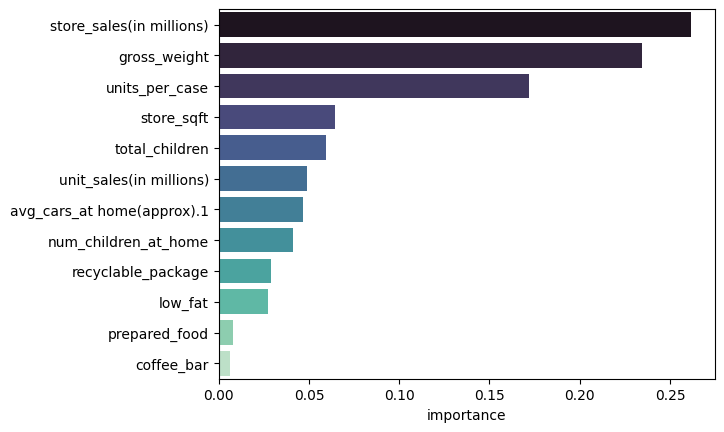

In [21]:
imp = rfr.feature_importances_
imp = pd.DataFrame(imp.T, columns = ['importance'],index=features.columns ).sort_values(by='importance', ascending = False)
pal = sns.color_palette("mako", len(imp))
sns.barplot(data = imp, y= imp.index, x='importance', palette = pal)
plt.show()

### XGBoost

In [23]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train,y_train)
y_pred= xgb_model.predict(X_test)

In [24]:
xgb_normal = model_validation(y_test, y_pred)

r2_score :0.09866094005836856
mean absolute error :24.28123516814819
root mean squared log error :0.3037177630902229
root mean squared error :28.421869793500132


In [26]:
def best_params(trial):
    params = {
        'objective': 'reg:squaredlogerror',
        'eval_metric':'rmsle',
        'learning_rate': trial.suggest_float('learning_rate',0.01,1),
        'n_estimators': trial.suggest_int('n_estimators',100,1000),
        'max_depth': trial.suggest_int('max_depth', 3,12),
        'subsample': trial.suggest_float('subsample',0.6,0.95,step = 0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree',0.1,1,step = 0.1),
        'gamma': trial.suggest_float('gamma',0.1,1)
    }
    
    model = XGBRegressor(**params)
    
    model.fit(X_train,y_train)
    y_pred= model.predict(X_test)
    
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    
    return rmsle

In [43]:
# study = optuna.create_study(direction = 'minimize')
# study.optimize(best_params, n_trials = 1000)
# best_params = study.best_params

In [40]:
best_params = {'learning_rate': 0.8457197375240337, 
               'n_estimators': 967, 'max_depth': 12, 
               'subsample': 0.95, 'colsample_bytree': 1.0, 
               'gamma': 0.1498116820644617}

In [57]:
xgb_model_optuna = XGBRegressor(**best_params)
xgb_model.fit(X_train,y_train)
y_pred= xgb_model.predict(X_test)

In [58]:
xgb_optuna_rmsle = model_validation(y_test, y_pred)

r2_score :0.09866094005836856
mean absolute error :24.28123516814819
root mean squared log error :0.3037177630902229
root mean squared error :28.421869793500132


In [59]:
rmsle_li = {'Linear Regression ':lr_rmsle,
           'Decision Tree': dtr_rmsle,
           'Random Forest': rf_rmsle,
           'XGB default': xgb_normal,
           'XGB with Optuna': xgb_optuna_rmsle}

values = list(rmsle_li.values())
keys = list(rmsle_li.keys())
column = ['Root Mean Squared Log Error']
pd.DataFrame(values, index= keys, columns = column).sort_values('Root Mean Squared Log Error')

,Root Mean Squared Log Error
XGB default,0.303718
XGB with Optuna,0.303718
Random Forest,0.310113
Linear Regression,0.318444
Decision Tree,0.421201


##### XG Boost is a widely used and powerful library, and when combined with hyperparameter tuning using tools like Optuna, it becomes even more effective. Despite its capabilities, in this particular case, I encountered the same error when using XG Boost with default parameters and after tuning hyperparameters with Optuna. It is possible that the error can be further reduced by performing more advanced feature engineering and fine-tuning additional parameters using Optuna. However, for the time being, I am accepting with the error value of 0.303718.

In [61]:
ss_ = StandardScaler()
ss_.fit_transform(features)
df_test = ss_.transform(df_test)

C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:409: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [62]:
clf = XGBRegressor(**best_params)
clf.fit(features, target)
y_pred =clf.predict(df_test)

### Submission

In [65]:
preds = sample
preds['cost'] = y_pred

In [66]:
preds.head()

,id,cost
0,360336,215.313919
1,360337,136.852661
2,360338,202.550415
3,360339,136.852661
4,360340,136.852661


In [72]:
preds.shape

(240224, 2)

In [73]:
preds.to_csv('D:\Data Science\kaggle competitions\playground series season 3 episode 11\submission.csv', index = False)